# Introduction

**Description**
Our team is currently developing a new platform that brings AI capabilities to all JetBrains products. Part of this platform is based on compact and efficient language models which help users write better text, no matter what JetBrains product they are using. We are looking for an ML Engineer who can contribute to our grammar error correction service within our writing assistance project. There are several open ideas which we would potentially like to explore:

* Fine-tuning large language models for the grammar error correction tasks
* Experimenting with ensembling and ranking of single-model systems
* Adapting recent advances in text-editing to grammar error correction
* Augmenting and enhancing our datasets using LLMs or alternative methods

Of course, we also welcome your own ideas and the application of other research papers.

**Test task 2**
One of the most widespread applications of natural language processing is to correct erroneous texts, in particular incorrectly spelled words. ***Your goal is to explore the existing spell checking tools and evaluate them***.

We suggest the following steps for this test assignment:

* Collect the data for evaluation, e.g. you can use publicly available datasets, generate synthetic data, combine different approaches – it's up to you.
* Research and choose the metrics you want to use for evaluation.
* Explore the existing spell checkers (e.g. libraries, fine-tuned models, LLMs), pick some you like and evaluate them on the created test set.
* Analyse the results and think about the strengths and weaknesses of each spell checker, as well as the reasons for that. Think about how they could be improved.

As a result, you should provide a link to a repository containing the source code and documentation, e.g.:

* Scripts containing data preparation and evaluation
* Documentation describing datasets, tools and metrics you used
* A short report that describes your approach and ideas summarises the results and discusses the challenges you encountered
* Instructions on how to run and locally reproduce the results

# Setup

In [1]:
import multiprocessing

multiprocessing.cpu_count()

4

In [2]:
%%capture
!pip install transformers==4.44.2 swifter==1.4.0 seaborn==0.13.1 nltk==3.8.1 python-Levenshtein==0.25.1

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Prepare the dataset

In [4]:
# links https://huggingface.co/datasets/jhu-clsp/jfleg
# https://www.kaggle.com/datasets/satishgunjal/grammar-correction/data
# https://www.kaggle.com/code/dariocioni/gec-with-transformers-from-scratch
# https://github.com/mhagiwara/github-typo-corpus?tab=readme-ov-file

In [5]:
#!git clone https://github.com/Sopralapanca/jet-brains-internship-challenge

In [6]:
import pandas as pd

splits = {'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df_valid = pd.read_parquet("hf://datasets/jhu-clsp/jfleg/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/jhu-clsp/jfleg/" + splits["test"])
df = pd.concat([df_valid, df_test])

#optionally add other senteces from other dataframes or generate sintetic data

In [7]:
df.head()

,sentence,corrections
0,So I think we can not live if old people could...,[So I think we would not be alive if our ances...
1,For not use car .,"[Not for use with a car . , Do not use in the ..."
2,Here was no promise of morning except that we ...,"[Here was no promise of morning , except that ..."
3,Thus even today sex is considered as the least...,"[Thus , even today , sex is considered as the ..."
4,image you salf you are wark in factory just to...,[Imagine yourself you are working in factory j...


NOTE

una analisi potrebbe essere fatta su quali sono gli errori grammaticali più comuni? se abbreviazioni, capital case, errori nei verbi, typo ecc

In [8]:
len(df)

1503

In [9]:
df = df.explode("corrections")
len(df)

6012

In [10]:
df = df.drop_duplicates(subset=["sentence", "corrections"])
len(df)

4880

In [11]:
missing_values = df.isnull().sum()
missing_values

sentence       0
corrections    0
dtype: int64

In [12]:
df["sentence"] = df["sentence"].str.strip()
df["corrections"] = df["corrections"].str.strip()

In [13]:
df.head(10)

,sentence,corrections
0,So I think we can not live if old people could...,So I think we would not be alive if our ancest...
0,So I think we can not live if old people could...,So I think we could not live if older people d...
0,So I think we can not live if old people could...,So I think we can not live if old people could...
0,So I think we can not live if old people could...,So I think we can not live if old people can n...
1,For not use car .,Not for use with a car .
1,For not use car .,Do not use in the car .
1,For not use car .,Car not for use .
1,For not use car .,Can not use the car .
2,Here was no promise of morning except that we ...,"Here was no promise of morning , except that w..."
2,Here was no promise of morning except that we ...,"Here , there was no promise of morning , excep..."


In [14]:
df["sentence"] = df["sentence"].str.replace(r'^\d+\.\s+', '', regex=True)
df["corrections"] = df["corrections"].str.replace(r'^\d+\.\s+', '', regex=True)

In [15]:
df.head(10)

,sentence,corrections
0,So I think we can not live if old people could...,So I think we would not be alive if our ancest...
0,So I think we can not live if old people could...,So I think we could not live if older people d...
0,So I think we can not live if old people could...,So I think we can not live if old people could...
0,So I think we can not live if old people could...,So I think we can not live if old people can n...
1,For not use car .,Not for use with a car .
1,For not use car .,Do not use in the car .
1,For not use car .,Car not for use .
1,For not use car .,Can not use the car .
2,Here was no promise of morning except that we ...,"Here was no promise of morning , except that w..."
2,Here was no promise of morning except that we ...,"Here , there was no promise of morning , excep..."


In [16]:
# get all the rows where sentence is ""

df_temp = df[df["sentence"] == ""]
len(df_temp)

1

In [17]:
# delete rows from df where sentence is ""
print(len(df))
df = df[df["sentence"] != ""]
len(df)

4880


4879

# Data Analysis

In [18]:
import matplotlib.pyplot as plt

Visualization of the sentence lengths

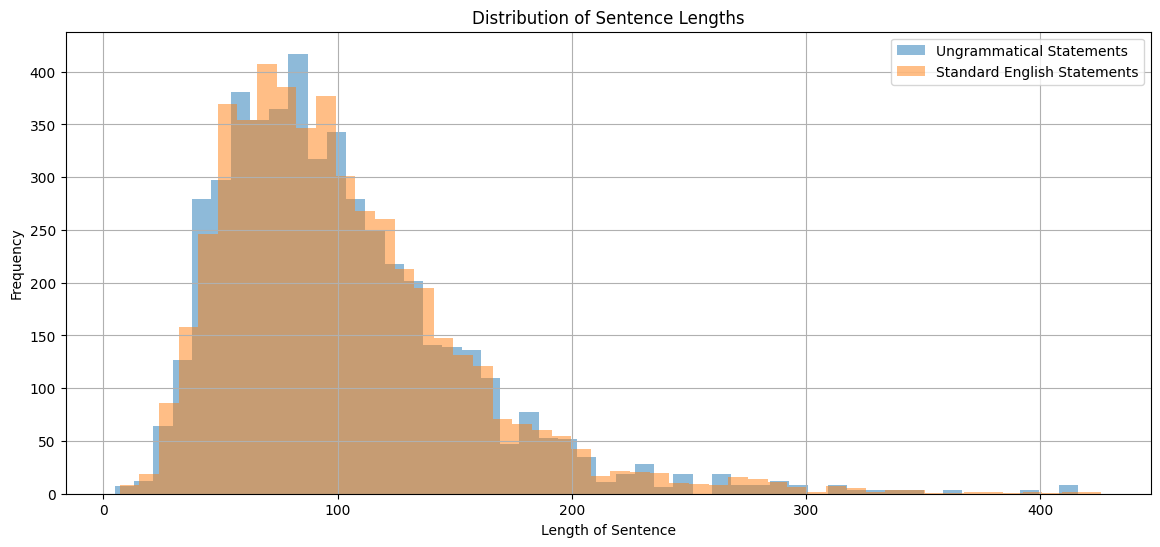

In [19]:
def plot_sentence_length_distribution(sentences: pd.Series, corrections: pd.Series):
  """
  Plot the distribution of sentence lengths for grammatical and non-grammatical sentences.
  param: sentences: pd.Series for ungrammatical sentences
  param: corrections: pd.Series for grammatical sentences
  """

  plt.figure(figsize=(14, 6))
  plt.hist(sentences.str.len(), bins=50, alpha=0.5, label='Ungrammatical Statements')
  plt.hist(corrections.str.len(), bins=50, alpha=0.5, label='Standard English Statements')
  plt.title('Distribution of Sentence Lengths')
  plt.xlabel('Length of Sentence')
  plt.ylabel('Frequency')
  plt.legend()
  plt.grid(True)

  plt.show()

plot_sentence_length_distribution(df["sentence"], df["corrections"])

Word Frequency Analysis

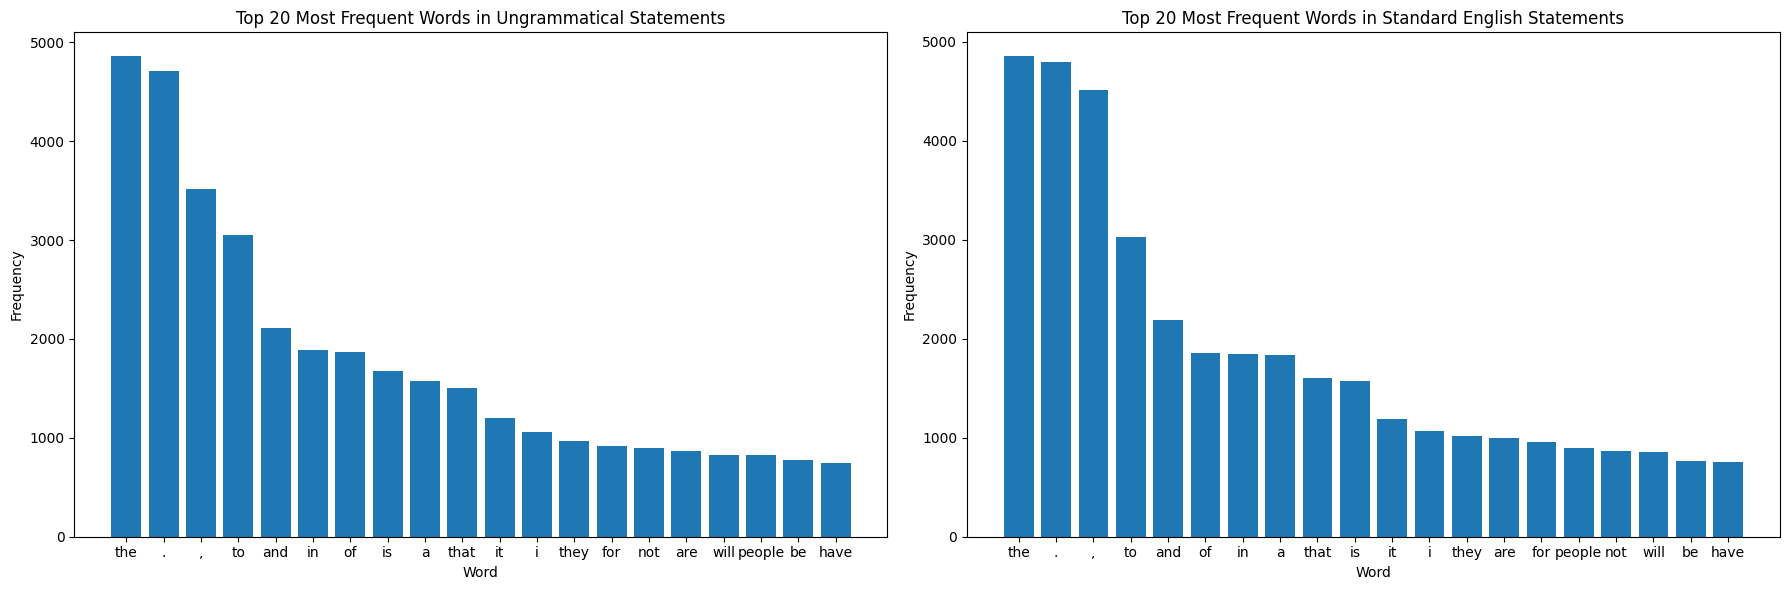

In [20]:
from collections import Counter
from nltk.tokenize import word_tokenize


def word_frequency(sentences: pd.Series, corrections: pd.Series):

    # Method to compute word frequency of a series of strings
    def compute_word_frequency(texts):
      words = []
      for text in texts:
        words.extend(word_tokenize(text.lower()))
      return Counter(words)

    # Compute word frequency for ungrammatical and grammatical sentences
    ungrammatical_word_freq = compute_word_frequency(sentences)
    grammatical_word_freq = compute_word_frequency(corrections)

    # plot the top 20 most frequent words side by side
    ungrammatical_word_freq_df = pd.DataFrame(ungrammatical_word_freq.most_common(20), columns=['Word', 'Frequency'])
    grammatical_word_freq_df = pd.DataFrame(grammatical_word_freq.most_common(20), columns=['Word', 'Frequency'])


    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.bar(ungrammatical_word_freq_df['Word'], ungrammatical_word_freq_df['Frequency'])
    plt.title('Top 20 Most Frequent Words in Ungrammatical Statements')
    plt.xlabel('Word')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.bar(grammatical_word_freq_df['Word'], grammatical_word_freq_df['Frequency'])
    plt.title('Top 20 Most Frequent Words in Standard English Statements')
    plt.xlabel('Word')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

word_frequency(df["sentence"], df["corrections"])


la virgola è molto meno frequente nel df con errori grammaticali. Molte persone sbagliano la virgola
La distribuzione di "in" e "of"cambia tra i due plot

POS tagging

In [21]:
from nltk import pos_tag

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

<Figure size 3000x1000 with 0 Axes>

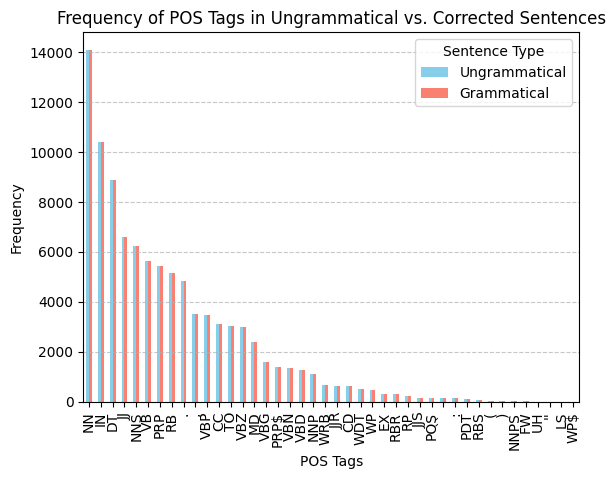

In [22]:
def pos_tag_distributions(sentences: pd.Series, corrections: pd.Series):

    # Method to compute pos tagging on a series of strings
    def pos_tagging(texts):
      tagged_sentences = []
      for sentence in sentences:
          tokens = word_tokenize(sentence)
          tagged = pos_tag(tokens)
          tagged_sentences.extend(tagged)
      return tagged_sentences

    # Compute pos tagging for ungrammatical and grammatical sentences
    pos_tag_ungrammatical = pos_tagging(sentences)
    pos_tag_grammatical = pos_tagging(corrections)

    # Count the frequency of each POS tag
    ungrammatical_pos_counts = pd.Series([tag for _, tag in pos_tag_ungrammatical]).value_counts()
    corrected_pos_counts = pd.Series([tag for _, tag in pos_tag_grammatical]).value_counts()

    # Convert to DataFrame for visualization
    pos_df = pd.DataFrame({
        'Ungrammatical': ungrammatical_pos_counts,
        'Grammatical': corrected_pos_counts
    }).fillna(0)

    # Plot
    plt.figure(figsize=(30, 10))
    pos_df.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Frequency of POS Tags in Ungrammatical vs. Corrected Sentences')
    plt.xlabel('POS Tags')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)  # Rotate the labels vertically
    plt.legend(title='Sentence Type')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

pos_tag_distributions(df["sentence"], df["corrections"])

Error Correction Difficulty Index

In [23]:
import numpy as np
from Levenshtein import distance as levenshtein_distance
import swifter

# Function to generate corrections using T5
def difficulty_index(ungrammatical: str, corrected: str):
    """
    Compute the difficulty index of a corrected sentence compared to an ungrammatical sentence.
    param: ungrammatical: str for ungrammatical sentence
    param: corrected: str for grammatical sentence
    return: float between 0 and 1, where 1 is the most difficult and 0 is the easiest.
    """


    edit_distance = levenshtein_distance(ungrammatical, corrected)
    normalized_distance = edit_distance / max(len(ungrammatical), len(corrected))

    return normalized_distance

# Apply the model to each sentence and store the correction in a new column
df['difficulty_index'] = df.swifter.apply(lambda row: difficulty_index(row['sentence'], row['corrections']), axis=1)
df.head()


2024-09-18 17:07:59,658	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/opt/conda/lib/python3.10/site-packages/swifter/swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4879 [00:00<?, ?it/s]

,sentence,corrections,difficulty_index
0,So I think we can not live if old people could...,So I think we would not be alive if our ancest...,0.550459
0,So I think we can not live if old people could...,So I think we could not live if older people d...,0.440367
0,So I think we can not live if old people could...,So I think we can not live if old people could...,0.055046
0,So I think we can not live if old people could...,So I think we can not live if old people can n...,0.254545
1,For not use car .,Not for use with a car .,0.458333


In [24]:
!pip install errant

In [32]:
!pip install spacy

In [31]:
df.head(6)

,sentence,corrections,difficulty_index
0,So I think we can not live if old people could...,So I think we would not be alive if our ancest...,0.550459
0,So I think we can not live if old people could...,So I think we could not live if older people d...,0.440367
0,So I think we can not live if old people could...,So I think we can not live if old people could...,0.055046
0,So I think we can not live if old people could...,So I think we can not live if old people can n...,0.254545
1,For not use car .,Not for use with a car .,0.458333
1,For not use car .,Do not use in the car .,0.391304


In [35]:
import errant
import spacy

annotator = errant.load('en')
nlp = spacy.load("en_core_web_sm")

# Function to get error types using ERRANT
def get_error_types(sentence, correction):
    orig = nlp(sentence)
    cor = nlp(correction)
    
    # Align the original and corrected sentence to detect errors
    alignment = annotator.annotate(orig, cor)
    # Extract the error types (e.g., VERB:TENSE, NOUN:NUM)
    error_types = [error.type for error in alignment]
    return error_types

# Apply the function to each row
df['error'] = df.swifter.apply(lambda row: get_error_types(row['sentence'], row['corrections']), axis=1)



Pandas Apply:   0%|          | 0/4879 [00:00<?, ?it/s]

                                              sentence  \
0    So I think we can not live if old people could...   
0    So I think we can not live if old people could...   
0    So I think we can not live if old people could...   
0    So I think we can not live if old people could...   
1                                    For not use car .   
..                                                 ...   
745  In other words , the image in the TV comercial...   
745  In other words , the image in the TV comercial...   
745  In other words , the image in the TV comercial...   
746  Members gather money for the funeral and help ...   
746  Members gather money for the funeral and help ...   

                                           corrections  difficulty_index  \
0    So I think we would not be alive if our ancest...          0.550459   
0    So I think we could not live if older people d...          0.440367   
0    So I think we can not live if old people could...          0.055046   

In [36]:
df.head()

,sentence,corrections,difficulty_index,error
0,So I think we can not live if old people could...,So I think we would not be alive if our ancest...,0.550459,"[R:VERB:TENSE, M:VERB, R:SPELL, R:OTHER, R:NOU..."
0,So I think we can not live if old people could...,So I think we could not live if older people d...,0.440367,"[R:VERB:TENSE, R:ADJ:FORM, R:VERB:TENSE, R:VER..."
0,So I think we can not live if old people could...,So I think we can not live if old people could...,0.055046,"[R:SPELL, R:SPELL, R:SPELL]"
0,So I think we can not live if old people could...,So I think we can not live if old people can n...,0.254545,"[R:VERB:TENSE, M:DET, R:SPELL, R:SPELL, U:CONJ..."
1,For not use car .,Not for use with a car .,0.458333,"[R:WO, M:OTHER]"


In [ ]:
# reverse of explode, groupby sentences and add all the corrections to a list, average the difficulty index column
df = df.groupby(['sentence']).agg({'corrections': lambda x: list(x), 'difficulty_index': 'mean'}).reset_index()
df

In [ ]:
# compute sentence length, helpful for smart batching
df['sentence_length'] = df['sentence'].str.len()
df = df.sort_values(by='sentence_length')

# Model Corrections

In [37]:
# reduce df to 100 examples
df_short = df.sample(10)
len(df_short)

"""
different t5 models
google-t5/t5-small
google-t5/t5-base
google-t5/t5-large
google-t5/t5-3b
google-t5/t5-11b
"""

'\ndifferent t5 models\ngoogle-t5/t5-small\ngoogle-t5/t5-base\ngoogle-t5/t5-large\ngoogle-t5/t5-3b\ngoogle-t5/t5-11b\n'

In [41]:
# add a column namend length to df_short, insert the lenght of sentece
df_short['length'] = df_short['sentence'].str.len()
# sort df_short by length
df_short = df_short.sort_values(by='length')

In [42]:
%%time
from tqdm import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline

# Load the gpt2 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')

# Function to generate corrections using GPT2
def t5_corrections(sentences, batch_size):
    corrected_sentences = []
    for i in tqdm(range(0, len(sentences), batch_size)):
        # Take a batch of sentences
        batch = sentences[i:i+batch_size]

        # Prepare the batch input
        input_texts = ["grammar: " + sentence for sentence in batch]
        inputs = tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

        # Generate corrections for the entire batch
        outputs = model.generate(**inputs, max_length=512, num_beams=4, early_stopping=True)

        # Decode all the generated sentences in the batch
        batch_corrected = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Append the batch results to the final list
        corrected_sentences.extend(batch_corrected)

    return corrected_sentences

# Apply the model to each sentence and store the correction in a new column
df_short['t5_corrections'] = t5_corrections(df_short['sentence'].tolist(), batch_size=16) # ci sta di meno

100%|██████████| 1/1 [00:06<00:00,  6.20s/it]

CPU times: user 12.9 s, sys: 298 ms, total: 13.1 s
Wall time: 7.44 s


In [43]:
%%time

from tqdm import tqdm
import torch
from transformers import BartTokenizer, BartForConditionalGeneration

# Load the bart model and tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')

# try also bart-base

# Function to generate corrections using BART
def bart_correctionions(sentences, batch_size):

    corrected_sentences = []
    for i in tqdm(range(0, len(sentences), batch_size)):
        # Take a batch of sentences
        batch = sentences[i:i+batch_size]

        # Prepare the batch input
        input_texts = ["grammar: " + sentence for sentence in batch]
        inputs = tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

        # Generate corrections for the entire batch
        outputs = model.generate(**inputs, max_length=512, num_beams=4, early_stopping=True)

        # Decode all the generated sentences in the batch
        batch_corrected = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Append the batch results to the final list
        corrected_sentences.extend(batch_corrected)

    return corrected_sentences

# Apply the model to each sentence and store the correction in a new column
df_short['bart_correction'] = bart_correctionions(df_short['sentence'].tolist(), batch_size=16) # ci sta di meno

100%|██████████| 1/1 [00:26<00:00, 26.55s/it]

CPU times: user 52.3 s, sys: 4.79 s, total: 57.1 s
Wall time: 30 s


In [47]:
# Display the DataFrame with original and corrected sentences
df_short[['sentence', 'bart_correction', 't5_corrections']]

,sentence,bart_correction,t5_corrections
508,"Some people might say""hey how does energy come...","grammar: Some people might say""hey how does en...",.
145,this is because of their knowledge on many sub...,grammar: this is because of their knowledge on...,: this is because of their knowledge on many s...
58,"For this reason , the number of cars would be ...","grammar: For this reason, the number of cars w...",grammar:
80,I mean our homecontry because we can speak Jap...,grammar: I mean our homecontry because we can ...,I mean our homecontry because we can speak Jap...
24,If they prefer to choose cars than motor bike ...,grammar: If they prefer to choose cars than mo...,entailment
6,I want to talk about nocive or bad products li...,grammar: I want to talk about nocive or bad pr...,False
251,"In America , alot of family have more than one...","grammar: In America, alot of family have more ...",True
364,"From my personal experience , when I was very ...","grammar: From my personal experience, when I w...",True
465,It 's slow process but after the process they ...,grammar: It's slow process but after the proce...,True
680,For example if my friends talking about their ...,grammar: For example if my friends talking abo...,True


In [ ]:
# optimizations https://huggingface.co/docs/transformers/main/en/llm_optims
#speed up
#model.generation_config.cache_implementation = "static" t5 does not support static
#model.forward = torch.compile(model.forward, mode="reduce-overhead", fullgraph=True)
